Nome: Gustavo Duarte Serafim

RA: 11054016

Disciplina: Filtragem Adaptativa

Professor: Ricardo Suyama

# Laboratório 4 - Algoritmo RLS

In [0]:
import numpy as np
from numpy import matlib as matlab
from numpy.fft import fft
import math
from scipy.signal import lfilter as filter
import scipy.signal as signal
import matplotlib.pyplot as plt

Recursive Least Squares (RLS)

Resumo dos passos do algoritmo RLS: 

$$ \textbf{k}(n) = \dfrac{\lambda^{-1} \textbf{P}(n-1) \textbf{s}(n)}{1+\lambda^{-1} \textbf{s}(n)^{T} \textbf{P}(n-1) \textbf{s}(n)} $$

$$ \alpha(n) = d(n) - \textbf{w}(n)^{T}\textbf{s}(n)$$
$$ \textbf{w}(n) = \textbf{w}(n-1) + \alpha(n) \textbf{k}(n) $$ 

$$ \textbf{P}(n) = \lambda^{-1} \textbf{P}(n-1) - \lambda^{-1} \textbf{k}(n) \textbf{s}(n)^{T} \textbf{P}(n-1)$$

Em geral, $\textbf{w}(0) = 0$ (vetor de zeros) e $\textbf{P}(0) = \delta \textbf{I}$ (matriz identidade multiplicada por um valor $\delta$ grande, 100 por exemplo). $\lambda$ pode ser um valor próximo de 1 (0.99, 0.95, etc).

### 1. Escreva uma função no Matlab (Python, no caso) que receba como parâmetros um vetor $x$ com amostras do sinal de entrada de um vetor $d$ com amostras de um sinal de referência e retorne o vetor com os coeficientes do filtro. 

### 2. Implemente de maneira que seja possível obter os filtros com um número arbitrário de coeficientes (no caso $L$ coeficientes).

In [0]:
def my_RLS(x, d, L = 2, lbda = 0.99, partida = [0 for n in range(0, 100)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]
  delta = 100

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]

  # Construindo a matriz P(0)

  P = delta*np.identity(nCoeffs)
  
  # Inicialização do filtro 
  w_RLS = np.zeros((nCoeffs,1))
  w_RLS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_RLS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    k = ((1/lbda)*np.dot(P, X[:, i]))/(1+(1/lbda)*np.dot(X[:, i], np.dot(P, X[:, i])))
    y_RLS = np.dot(w_RLS.transpose(), X[:, i])
    e = d[i] - y_RLS;
    w_RLS = w_RLS + e*k.reshape(nCoeffs, 1);
    w_RLS_hist[:, i] = w_RLS.reshape(nCoeffs,)
    P = (1/lbda)*P - (1/lbda)*np.dot(k.reshape(nCoeffs, 1), np.dot(X[:, i].reshape(1, nCoeffs),P))

  return w_RLS, w_RLS_hist

# 3. Aplicar o algoritmo em um sinal gaussiano branco para tentar obter o filtro de Wiener que aproxime o comportamento de um sistema com função de transferência dada por: 

$$ H(z) = 1 + 1/2z^{-1} + 1/4z^{-2} +1/8z^{-3} + 1/16z^{-4} $$



[[0.99998338]
 [0.49999243]
 [0.24999594]
 [0.1249971 ]
 [0.06249657]] 



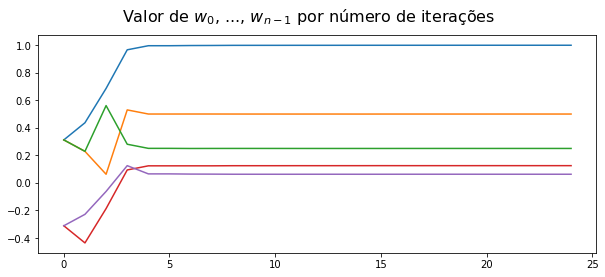

In [3]:
# Definições
nSamples = 10000                  # Número de amostras
h = [1, 0.5, 0.25, 0.125, 0.0625] # Coeficientes do Canal/Sistema
nCoeffs = len(h)                  # Número de coeficientes do filtro


# Geração das amostras dos sinais transmitido, desejado e recebido
x = np.sign(np.random.randn(nSamples))
y = filter(h, 1, x)
d = y

w, w_hist = my_RLS(x[0:200], d[0:200], nCoeffs)

print(w, '\n')
fig = plt.figure(figsize = [10, 4]) 
fig.suptitle("Valor de $w_0$, ..., $w_{n-1}$ por número de iterações", fontsize = 16)
plt.plot(w_hist.transpose()[0:25])
plt.show()

Observamos que a solução convergiu para os valores exatos dos coeficientes da função de transferência original do sistema. Como se trata de um caso de identificação, faz sentido que o filtro de Wiener esperado tivesse os mesmos coeficientes do sistema, mostrando que o algoritmo de fato converge. 

# 4. Simular o algoritmo para diferentes passos de aprendizado e pontos de partida. 

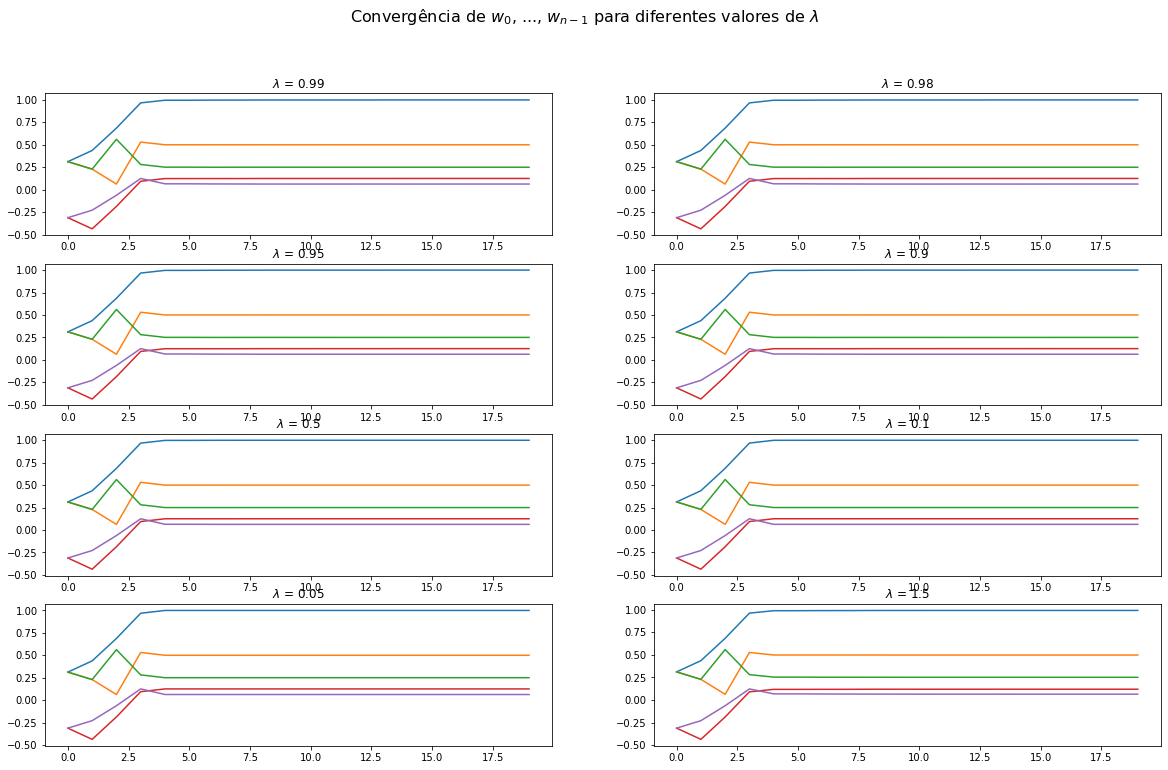

In [4]:
mu_array_SD = [0.99, 0.98, 0.95, 0.90, 0.50, 0.10, 0.05, 1.5]
cores = ['red', 'orange', 'gold', 'black', 'lime', 'cyan', 'pink']
pontos_de_partida = [[-0.5, -1.5], [0, 1.5], [1, 1], [0, 1.5], [-0.5, 1.5], [-0.5, 0.5], [0, 0.5]]

fig = plt.figure(figsize = [20, 12]) 
fig.suptitle("Convergência de $w_0$, ..., $w_{n-1}$ para diferentes valores de $\lambda$", fontsize = 16)

for i in range(0, len(mu_array_SD)): 
  w, w_hist = my_RLS(x, d, nCoeffs, mu_array_SD[i])
  plt.subplot(4, 2, i+1)
  plt.plot(w_hist.transpose()[0:20])
  plt.title('$\lambda$ = '+str(mu_array_SD[i]))
  
plt.show()

Para um ponto de partida localizado em $\textbf{W} = \textbf{0}$, valores entre 0 e 1 para $\lambda$ mostraram praticamente a mesma velocidade de convergência para todos os casos de teste, mesmo quando $\lambda$ estava longe de 1 (como 0.5, 0.1 e 0.05). Além disso, o Algoritmo convergiu mesmo quando $\lambda > 1$. 

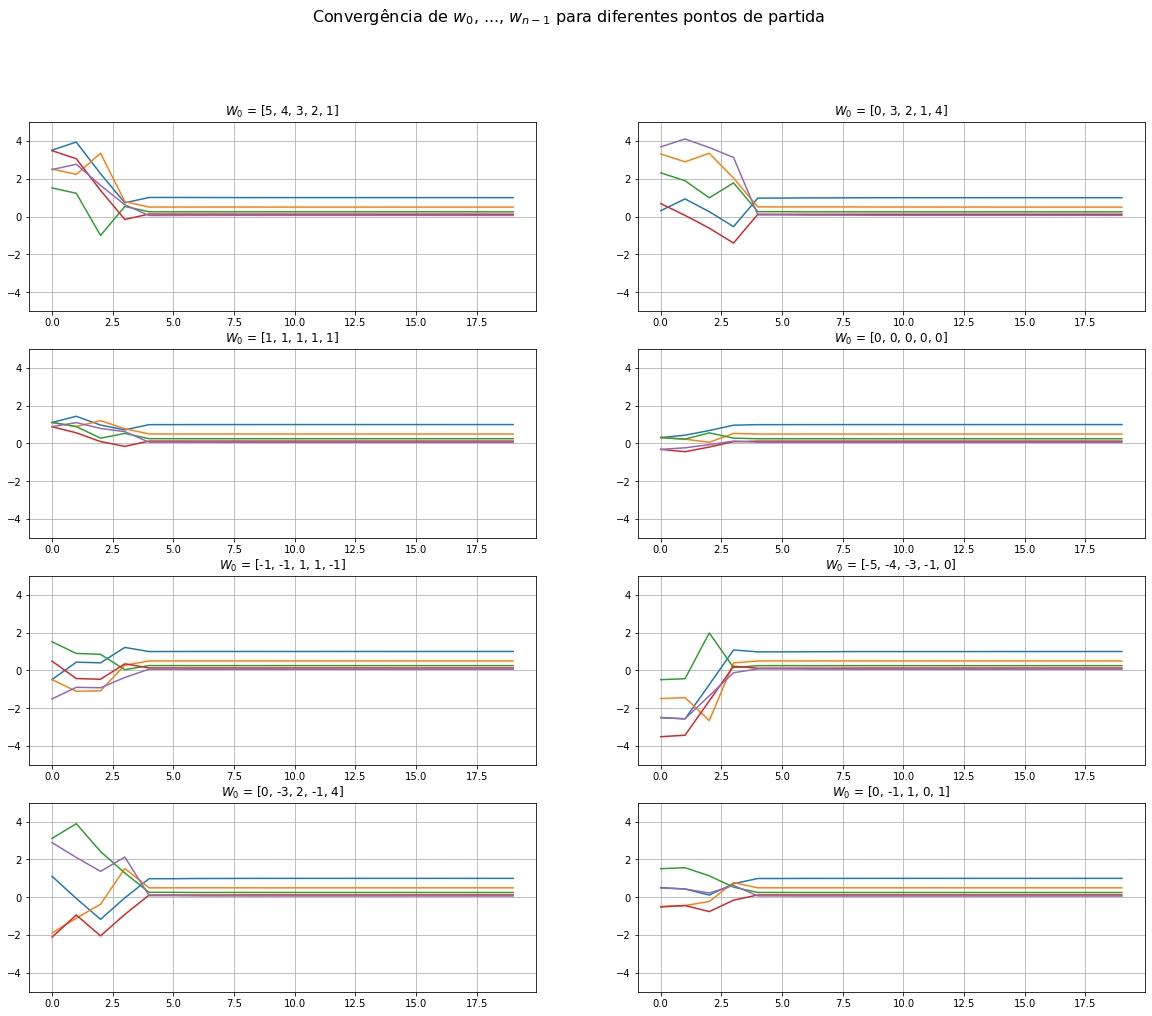

In [5]:
#mu_array_SD = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.18, 0.2]
cores = ['red', 'orange', 'gold', 'black', 'lime', 'cyan', 'pink']
pontos_de_partida = [[5, 4, 3, 2, 1], 
                     [0, 3, 2, 1, 4], 
                     [1, 1, 1, 1, 1], 
                     [0, 0, 0, 0, 0], 
                     [-1, -1, 1, 1, -1], 
                     [-5, -4, -3, -1, 0],
                     [0, -3, 2, -1, 4], 
                     [0, -1, 1, 0, 1]]

fig = plt.figure(figsize = [20, 16]) 
fig.suptitle("Convergência de $w_0$, ..., $w_{n-1}$ para diferentes pontos de partida", fontsize = 16)

for i in range(0, len(mu_array_SD)): 
  w, w_hist = my_RLS(x, d, nCoeffs, partida = pontos_de_partida[i])
  plt.subplot(4, 2, i+1)
  plt.plot(w_hist.transpose()[0:20])
  plt.title('$W_0$ = '+str(pontos_de_partida[i]))
  plt.ylim(-5, 5)
  plt.grid()

plt.show()


Para diferentes pontos de partida, vemos claramente que pontos mais próximos dos valores de convergência são bastante privilegiados, chegando a convergir em menos de 5 iterações. Nenhum dos pontos de partida observados mostrou dificuldade em convergir aos valores do filtro do sistema, chegando sempre a convergir em menos de 8 iterações. Esse resultado está de acordo com o esperado já que o filtro do sistema é um filtro FIR. Vale a pena observar que neste caso em particular do filtro FIR, o algoritmo converge *exatamente* aos coeficientes do sistema, com o erro chegando a zero. 

<class 'numpy.ndarray'>


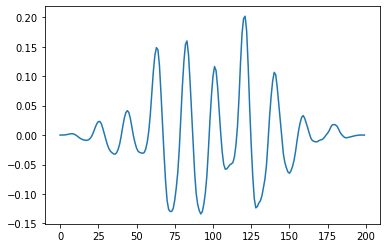

In [37]:

sound = np.array([-0.00000000e+00,  1.58827754e-06,  4.51507078e-05,  2.08209299e-04,
        5.59664626e-04,  1.09887266e-03,  1.72507065e-03,  2.22304717e-03,
        2.29811102e-03,  1.72432353e-03,  4.82922821e-04, -1.28396579e-03,
       -3.32110795e-03, -5.26497980e-03, -6.78293662e-03, -7.87031005e-03,
       -8.63223314e-03, -8.97980052e-03, -8.65216021e-03, -7.38370874e-03,
       -4.77641484e-03, -3.22374102e-04,  5.90890581e-03,  1.28933862e-02,
        1.89283310e-02,  2.27347549e-02,  2.31289406e-02,  1.91536644e-02,
        1.12992996e-02,  1.64814772e-03, -7.91516739e-03, -1.66118074e-02,
       -2.34263175e-02, -2.76363338e-02, -2.99919394e-02, -3.18879456e-02,
       -3.24533340e-02, -2.99573434e-02, -2.42213552e-02, -1.49530446e-02,
       -1.39038462e-03,  1.44044349e-02,  2.84728946e-02,  3.79526116e-02,
        4.14349938e-02,  3.82179788e-02,  2.77207378e-02,  1.28980066e-02,
       -1.47000789e-03, -1.30678360e-02, -2.18921438e-02, -2.73991567e-02,
       -2.94582155e-02, -3.02691888e-02, -3.09701643e-02, -2.97346963e-02,
       -2.39158473e-02, -1.23004261e-02,  6.33407047e-03,  3.43206761e-02,
        7.06801739e-02,  1.07777300e-01,  1.35266488e-01,  1.48345918e-01,
        1.44868710e-01,  1.17963275e-01,  7.03633474e-02,  1.72410290e-02,
       -3.27656191e-02, -7.79354951e-02, -1.11206475e-01, -1.26284685e-01,
       -1.29570037e-01, -1.29564351e-01, -1.24559994e-01, -1.10173247e-01,
       -8.93722150e-02, -6.26643318e-02, -2.21088882e-02,  3.13224533e-02,
        8.37700693e-02,  1.25691286e-01,  1.53788212e-01,  1.59741239e-01,
        1.36409721e-01,  9.11971583e-02,  3.89179167e-02, -1.43504337e-02,
       -6.36981443e-02, -9.90361421e-02, -1.17719000e-01, -1.28096267e-01,
       -1.33826675e-01, -1.30172917e-01, -1.17264794e-01, -9.82925410e-02,
       -6.89935083e-02, -2.51720838e-02,  2.43640939e-02,  6.72870225e-02,
        9.96862823e-02,  1.16192606e-01,  1.09580030e-01,  8.20735187e-02,
        4.40158858e-02,  4.84619647e-03, -2.82209833e-02, -4.94750994e-02,
       -5.78331756e-02, -5.75331767e-02, -5.40108759e-02, -5.05973558e-02,
       -4.89454153e-02, -4.67132741e-02, -3.72736457e-02, -1.73526625e-02,
        1.40827581e-02,  6.25796647e-02,  1.22712061e-01,  1.72391793e-01,
        1.97802338e-01,  2.01656206e-01,  1.76920134e-01,  1.17898697e-01,
        4.59121646e-02, -1.72039794e-02, -6.97261366e-02, -1.08000274e-01,
       -1.23613880e-01, -1.21185668e-01, -1.15326325e-01, -1.11492000e-01,
       -1.03027656e-01, -8.90996898e-02, -7.40880845e-02, -5.01961964e-02,
       -1.10142726e-02,  3.12575968e-02,  6.52607621e-02,  9.13406490e-02,
        1.06385370e-01,  1.02493561e-01,  8.09795616e-02,  5.24221326e-02,
        2.32599873e-02, -6.21569443e-03, -3.15263488e-02, -4.68228231e-02,
       -5.57386111e-02, -6.27045994e-02, -6.47836822e-02, -6.07322630e-02,
       -5.32738341e-02, -4.28617160e-02, -2.75036862e-02, -8.91756354e-03,
        7.94703627e-03,  2.10863835e-02,  3.03852504e-02,  3.30371400e-02,
        2.82211567e-02,  2.02736256e-02,  1.17543135e-02,  2.59401966e-03,
       -5.27536200e-03, -9.35013072e-03, -1.06081325e-02, -1.13986822e-02,
       -1.14974646e-02, -1.00778940e-02, -8.53014126e-03, -7.84677752e-03,
       -6.44118786e-03, -3.33981494e-03,  2.88204391e-04,  3.46690878e-03,
        7.68926036e-03,  1.33893521e-02,  1.72780510e-02,  1.78622858e-02,
        1.72465603e-02,  1.54248506e-02,  1.07701499e-02,  5.23556359e-03,
        1.28655105e-03, -1.61687539e-03, -3.88405718e-03, -4.71417477e-03,
       -4.27681957e-03, -3.62350672e-03, -3.09713724e-03, -2.42483237e-03,
       -1.65094091e-03, -1.04460547e-03, -5.86499539e-04, -1.94739639e-04,
        3.07990372e-05,  6.85450614e-05,  2.86293656e-05,  0.00000000e+00])


plt.plot(sound)
pitch = np.ones(200)
w, w_hist = my_RLS(sound,sound,16)
print(type(sound))

In [35]:
w

array([[-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05],
       [-2.54199892e-05]])

In [36]:
pitch = np.ones(200)

zz = signal.lfilter(w,1,pitch)
plt.plot(zz)

ValueError: ignored